In [1]:
import pandas as pd
# import wget

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

**ПОЗАВТРАКАЛИ**

Стемминг (убираем лишнии куски слова):
**завтрак**<br>
Очень быстро, очень дешево и очень слабо.

Лемматизация (перевод в неопределенную форму для гл. и в им.падеж для сущ.):
**завтракать**<br>
Небыстро, сложно.

In [5]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

Не все слова равны, не все слова одинаково работают. К примеру, союзы и предлоги в нашей задаче никак не помогут, поэтому можем их выкидывать. (Но в задачах оценки стиля, к примеру, такие слова будут очень полезны).

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [8]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [9]:
with open('stopwords.txt', encoding="utf8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
stopword_ru[200:210]

['ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам']

In [11]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [12]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('позавтракали')[0].normal_form

'позавтракать'

In [13]:
news['title'].iloc[:2].apply(lambda x: clean_text(x))

C:\Users\7C77~1\AppData\Local\Temp/ipykernel_22688/1880867539.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [14]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:50<00:00, 539.91it/s]

Wall time: 50.1 s


In [15]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [16]:
type(news)

pandas.core.frame.DataFrame

In [17]:
type(news['title'])

pandas.core.series.Series

In [18]:
type(news['title'][0])

str

In [19]:
news['title'][0]

'заместитель председателя правительства рф сергей иванов избран председателем совета пбк цска  как сообщает прессслужба армейцев такое решение было единогласно принято на первом заседании совета клуба основной функцией этого органа будет обсуждение текущего состояния планирование и утверждение стратегии развития клуба на ближайшую перспективу  в состав совета вошли георгий полтавченко полномочный представитель президента в центральном федеральном округе алексей седов генералполковник начальник службы по защите конституционного строя и борьбе с терроризмом фсб рф  александр новак заместитель министра финансов рф вячеслав полтавцев заместитель генерального директора руководитель блока по взаимодействию с органами власти социальной и корпоративной политики гмк норильский никель  леонид исакович генеральный директор ооо ук спортивные проекты ольга плешакова генеральный директор трансаэро  александр провоторов  генеральный директор оао ростелеком  андрей лопатов эксигрок цска чемпион мира т

In [20]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [21]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [07:04<00:00, 63.63it/s]

Wall time: 7min 4s


А теперь в 3 строчки обучим нашу модель

In [22]:
# ?common_dictionary

In [23]:
news['title'][0]

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',
 'норильский',
 'никель',
 'леонид',
 'исакович',
 '

In [24]:
# news['title'].values

In [25]:
news.columns

Index(['doc_id', 'title'], dtype='object')

In [26]:
news.iloc[:3]

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."


In [24]:
news['title'].values[0]

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',
 'норильский',
 'никель',
 'леонид',
 'исакович',
 '

In [27]:
type(news['title'].values[1])

list

In [28]:
news['title'].iloc[:2].values

array([list(['заместитель', 'председатель', 'правительство', 'рф', 'сергей', 'иванов', 'избрать', 'председатель', 'совет', 'пбк', 'цска', 'прессслужба', 'армеец', 'решение', 'единогласно', 'принять', 'первый', 'заседание', 'совет', 'клуб', 'основной', 'функция', 'орган', 'обсуждение', 'текущий', 'состояние', 'планирование', 'утверждение', 'стратегия', 'развитие', 'клуб', 'близкий', 'перспектива', 'состав', 'совет', 'войти', 'георгий', 'полтавченко', 'полномочный', 'центральный', 'федеральный', 'округ', 'алексей', 'седов', 'генералполковник', 'начальник', 'служба', 'защита', 'конституционный', 'строй', 'борьба', 'терроризм', 'фсб', 'рф', 'александр', 'новак', 'заместитель', 'министр', 'финансы', 'рф', 'вячеслав', 'полтавец', 'заместитель', 'генеральный', 'директор', 'руководитель', 'блок', 'взаимодействие', 'орган', 'власть', 'социальный', 'корпоративный', 'политика', 'гмк', 'норильский', 'никель', 'леонид', 'исакович', 'генеральный', 'директор', 'ооо', 'ук', 'спортивный', 'проект', 'ол

In [29]:
type(news['title'].iloc[:2].values)

numpy.ndarray

In [30]:
temp_1 = list(news['title'].iloc[:2].values)
temp_1[:]

[['заместитель',
  'председатель',
  'правительство',
  'рф',
  'сергей',
  'иванов',
  'избрать',
  'председатель',
  'совет',
  'пбк',
  'цска',
  'прессслужба',
  'армеец',
  'решение',
  'единогласно',
  'принять',
  'первый',
  'заседание',
  'совет',
  'клуб',
  'основной',
  'функция',
  'орган',
  'обсуждение',
  'текущий',
  'состояние',
  'планирование',
  'утверждение',
  'стратегия',
  'развитие',
  'клуб',
  'близкий',
  'перспектива',
  'состав',
  'совет',
  'войти',
  'георгий',
  'полтавченко',
  'полномочный',
  'центральный',
  'федеральный',
  'округ',
  'алексей',
  'седов',
  'генералполковник',
  'начальник',
  'служба',
  'защита',
  'конституционный',
  'строй',
  'борьба',
  'терроризм',
  'фсб',
  'рф',
  'александр',
  'новак',
  'заместитель',
  'министр',
  'финансы',
  'рф',
  'вячеслав',
  'полтавец',
  'заместитель',
  'генеральный',
  'директор',
  'руководитель',
  'блок',
  'взаимодействие',
  'орган',
  'власть',
  'социальный',
  'корпоративный',
 

In [31]:
len(temp_1)

2

In [32]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [33]:
len(common_dictionary)

135645

In [34]:
common_dictionary[4]

'банк'

In [35]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(993, 1), (6129, 1), (12270, 1), (135645, 1)]

Все просто - это словарь наших слов

Запускаем обучение

In [36]:
N_topic = 20

In [37]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
# lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 0 ns


In [38]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/Lda_weight/var_2/model_weight.lda")
# lda.save(temp_file)

In [39]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [40]:
news['title'].iloc[:3]

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
2    [форвард, авангард, томаш, заборский, прокомме...
Name: title, dtype: object

In [41]:
type(news['title'].iloc[:3])

pandas.core.series.Series

In [42]:
type(news['title'])

pandas.core.series.Series

In [43]:
type(news['title'][0])

list

In [44]:
len(news['title'][0])

113

In [45]:
news['title'][0][0]

'заместитель'

In [57]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [58]:
len(news['title'][2])

39

In [59]:
lda[b[2]]

[(5, 0.091809094),
 (7, 0.22088374),
 (12, 0.48336077),
 (13, 0.16194047),
 (17, 0.021924196)]

In [60]:
# Создаем новый корпус документов, которые раньше не видели
# получаем список списков слов по новостям 
# [['заместитель','председатель',..,'пбк','цска'],['матч',..,'онлайнтрансляция','матч'],['форвард',..,'девять','хороший']]
other_texts = list(news['title'].iloc[:3]) 
# получаем список кортежей [[(0, 2),(1, 1),..,(90, 1)],[(91, 2),..,(123, 1)],[(47, 1),..,(152, 1)]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts] 

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.09151466),
 (7, 0.22092755),
 (12, 0.48334873),
 (13, 0.16208376),
 (17, 0.022043783)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [62]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: россия российский сша санкция закон власть рф
topic_1: млрд эксперт система новый проект журнал экономика
topic_2: исследование путин научный всё выяснить помощь россия
topic_3: вирус бензин индия устойчивость сон грунт электроника
topic_4: мышь выстрел нож перо калинин руководящий кусочек
topic_5: млн рубль банк население статья составить первый
topic_6: препарат торговый университет расследование последствие сократиться век
topic_7: задержать преступление уголовный мужчина летний тело улица
topic_8: украина гражданин украинский министерство фонд убийство сотрудник
topic_9: поверхность пенсия налог остров испытание конкурс звезда
topic_10: иран операция франция турецкий санкция французский армения
topic_11: станция обнаружить температура запуск смерть место житель
topic_12: обращение солнце девочка игра планета мотив команда
topic_13: россия газ российский европа всё первый технология
topic_14: тыс новый проект снижение рынок тысяча риск
topic_15: сша американский тело штат с

In [63]:
x

[(0,
  [('россия', 0.033054486),
   ('российский', 0.017499361),
   ('сша', 0.014270776),
   ('санкция', 0.01054873),
   ('закон', 0.010020147),
   ('власть', 0.009704835),
   ('рф', 0.009468152)]),
 (1,
  [('млрд', 0.0102276),
   ('эксперт', 0.009037004),
   ('система', 0.0070709176),
   ('новый', 0.007064849),
   ('проект', 0.006549649),
   ('журнал', 0.0064434754),
   ('экономика', 0.005896111)]),
 (2,
  [('исследование', 0.018726597),
   ('путин', 0.010245631),
   ('научный', 0.010230636),
   ('всё', 0.010043863),
   ('выяснить', 0.008431733),
   ('помощь', 0.008097564),
   ('россия', 0.0071582114)]),
 (3,
  [('вирус', 0.0860275),
   ('бензин', 0.051518083),
   ('индия', 0.04809383),
   ('устойчивость', 0.029075934),
   ('сон', 0.0285899),
   ('грунт', 0.02093805),
   ('электроника', 0.017300213)]),
 (4,
  [('мышь', 0.087359086),
   ('выстрел', 0.035988774),
   ('нож', 0.025183866),
   ('перо', 0.019354772),
   ('калинин', 0.0169223),
   ('руководящий', 0.016009372),
   ('кусочек',

In [64]:
topics_words

[(0, ['россия', 'российский', 'сша', 'санкция', 'закон', 'власть', 'рф']),
 (1, ['млрд', 'эксперт', 'система', 'новый', 'проект', 'журнал', 'экономика']),
 (2,
  ['исследование', 'путин', 'научный', 'всё', 'выяснить', 'помощь', 'россия']),
 (3,
  ['вирус', 'бензин', 'индия', 'устойчивость', 'сон', 'грунт', 'электроника']),
 (4, ['мышь', 'выстрел', 'нож', 'перо', 'калинин', 'руководящий', 'кусочек']),
 (5, ['млн', 'рубль', 'банк', 'население', 'статья', 'составить', 'первый']),
 (6,
  ['препарат',
   'торговый',
   'университет',
   'расследование',
   'последствие',
   'сократиться',
   'век']),
 (7,
  ['задержать',
   'преступление',
   'уголовный',
   'мужчина',
   'летний',
   'тело',
   'улица']),
 (8,
  ['украина',
   'гражданин',
   'украинский',
   'министерство',
   'фонд',
   'убийство',
   'сотрудник']),
 (9,
  ['поверхность',
   'пенсия',
   'налог',
   'остров',
   'испытание',
   'конкурс',
   'звезда']),
 (10,
  ['иран',
   'операция',
   'франция',
   'турецкий',
   'сан

In [65]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [66]:
lda[common_dictionary.doc2bow(news['title'].iloc[0])]

[(0, 0.14337529), (1, 0.0747298), (5, 0.04490455), (13, 0.7293644)]

In [67]:
lda_tuple_t = lda[common_dictionary.doc2bow(news['title'].iloc[0])]

In [68]:
lda_tuple_t

[(0, 0.14338641), (1, 0.07473496), (5, 0.04481826), (13, 0.72943443)]

In [69]:
tmp = zip([i[0] for i in lda_tuple_t], [i[1] for i in lda_tuple_t])
tmp_1 = dict(tmp)
tmp_1

{0: 0.14338641, 1: 0.07473496, 5: 0.04481826, 13: 0.72943443}

In [70]:
tmp

In [71]:
16 not in tmp_1

True

In [72]:
tmp_1[13]

0.72943443

In [73]:
output_vector_t = []
for i in range(20):
    if i not in tmp_1:
        output_vector_t.append(0)
    else:
        output_vector_t.append(tmp_1[i])
output_vector_t

[0.14338641,
 0.07473496,
 0,
 0,
 0,
 0.04481826,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.72943443,
 0,
 0,
 0,
 0,
 0,
 0]

In [74]:
np.array(output_vector_t)

array([0.14338641, 0.07473496, 0.        , 0.        , 0.        ,
       0.04481826, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.72943443, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [75]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.1433638 , 0.07471139, 0.        , 0.        , 0.        ,
       0.04501507, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.72928381, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [76]:
tmp_matr = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])

In [77]:
tmp_matr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.143372,0.074744,0.000000,0.0,0.0,0.044902,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.729356,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.164425,0.000000,0.050836,0.0,0.000000,0.000000,0.000000,0.341498,0.000000,0.000000,0.00000,0.000000,0.000000,0.422162,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.091747,0.000000,0.220898,0.0,0.000000,0.000000,0.000000,0.483365,0.161949,0.000000,0.00000,0.000000,0.021959,0.000000,0.000000
3,0.000000,0.000000,0.197871,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.028962,0.081705,0.000000,0.259379,0.404168,0.000000,0.00000,0.000000,0.000000,0.000000,0.018786
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.972032,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,0.000000,0.323147,0.223532,0.0,0.0,0.000000,0.055047,0.033462,0.0,0.000000,0.000000,0.345066,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
26996,0.301542,0.222124,0.000000,0.0,0.0,0.000000,0.041322,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.348740,0.000000,0.00000,0.000000,0.072115,0.000000,0.000000
26997,0.000000,0.083613,0.000000,0.0,0.0,0.301154,0.000000,0.000000,0.0,0.065071,0.000000,0.000000,0.000000,0.139727,0.103815,0.12064,0.024044,0.000000,0.082949,0.067759
26998,0.058968,0.302263,0.111353,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.303762,0.000000,0.200213,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [78]:
tmp_matr.columns = [f'topic_{i}' for i in range(N_topic)]

In [79]:
tmp_matr

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0.143372,0.074744,0.000000,0.0,0.0,0.044902,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.729356,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.164425,0.000000,0.050836,0.0,0.000000,0.000000,0.000000,0.341498,0.000000,0.000000,0.00000,0.000000,0.000000,0.422162,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.091747,0.000000,0.220898,0.0,0.000000,0.000000,0.000000,0.483365,0.161949,0.000000,0.00000,0.000000,0.021959,0.000000,0.000000
3,0.000000,0.000000,0.197871,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.028962,0.081705,0.000000,0.259379,0.404168,0.000000,0.00000,0.000000,0.000000,0.000000,0.018786
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.972032,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,0.000000,0.323147,0.223532,0.0,0.0,0.000000,0.055047,0.033462,0.0,0.000000,0.000000,0.345066,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
26996,0.301542,0.222124,0.000000,0.0,0.0,0.000000,0.041322,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.348740,0.000000,0.00000,0.000000,0.072115,0.000000,0.000000
26997,0.000000,0.083613,0.000000,0.0,0.0,0.301154,0.000000,0.000000,0.0,0.065071,0.000000,0.000000,0.000000,0.139727,0.103815,0.12064,0.024044,0.000000,0.082949,0.067759
26998,0.058968,0.302263,0.111353,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.303762,0.000000,0.200213,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [80]:
news

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."
...,...,...
26995,513441,"[учёный, токийский, университет, морской, наук..."
26996,513442,"[глава, кафедра, отечественный, история, xx, в..."
26997,513443,"[американский, учёный, уточнить, возраст, расп..."
26998,513444,"[последний, тропический, углеродный, цикл, чув..."


In [81]:
tmp_matr['doc_id'] = news['doc_id'].values
tmp_matr

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,doc_id
0,0.143372,0.074744,0.000000,0.0,0.0,0.044902,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.729356,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,6
1,0.000000,0.000000,0.000000,0.0,0.0,0.164425,0.000000,0.050836,0.0,0.000000,...,0.000000,0.341498,0.000000,0.000000,0.00000,0.000000,0.000000,0.422162,0.000000,4896
2,0.000000,0.000000,0.000000,0.0,0.0,0.091747,0.000000,0.220898,0.0,0.000000,...,0.000000,0.483365,0.161949,0.000000,0.00000,0.000000,0.021959,0.000000,0.000000,4897
3,0.000000,0.000000,0.197871,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.028962,...,0.000000,0.259379,0.404168,0.000000,0.00000,0.000000,0.000000,0.000000,0.018786,4898
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.972032,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,0.000000,0.323147,0.223532,0.0,0.0,0.000000,0.055047,0.033462,0.0,0.000000,...,0.345066,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,513441
26996,0.301542,0.222124,0.000000,0.0,0.0,0.000000,0.041322,0.000000,0.0,0.000000,...,0.000000,0.000000,0.348740,0.000000,0.00000,0.000000,0.072115,0.000000,0.000000,513442
26997,0.000000,0.083613,0.000000,0.0,0.0,0.301154,0.000000,0.000000,0.0,0.065071,...,0.000000,0.000000,0.139727,0.103815,0.12064,0.024044,0.000000,0.082949,0.067759,513443
26998,0.058968,0.302263,0.111353,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.303762,0.000000,0.200213,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,513444


In [82]:
tmp_matr = tmp_matr[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
tmp_matr

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.143372,0.074744,0.000000,0.0,0.0,0.044902,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.729356,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,4896,0.000000,0.000000,0.000000,0.0,0.0,0.164425,0.000000,0.050836,0.0,...,0.000000,0.000000,0.341498,0.000000,0.000000,0.00000,0.000000,0.000000,0.422162,0.000000
2,4897,0.000000,0.000000,0.000000,0.0,0.0,0.091747,0.000000,0.220898,0.0,...,0.000000,0.000000,0.483365,0.161949,0.000000,0.00000,0.000000,0.021959,0.000000,0.000000
3,4898,0.000000,0.000000,0.197871,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.081705,0.000000,0.259379,0.404168,0.000000,0.00000,0.000000,0.000000,0.000000,0.018786
4,4899,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.972032,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,513441,0.000000,0.323147,0.223532,0.0,0.0,0.000000,0.055047,0.033462,0.0,...,0.000000,0.345066,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
26996,513442,0.301542,0.222124,0.000000,0.0,0.0,0.000000,0.041322,0.000000,0.0,...,0.000000,0.000000,0.000000,0.348740,0.000000,0.00000,0.000000,0.072115,0.000000,0.000000
26997,513443,0.000000,0.083613,0.000000,0.0,0.0,0.301154,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.139727,0.103815,0.12064,0.024044,0.000000,0.082949,0.067759
26998,513444,0.058968,0.302263,0.111353,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.303762,0.000000,0.200213,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [83]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 49.7 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.143335,0.074704,0.00000,0.0,0.0,0.045230,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.729105,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,4896,0.000000,0.000000,0.00000,0.0,0.0,0.164139,0.0,0.050548,0.0,...,0.000000,0.0,0.341647,0.000000,0.0,0.0,0.0,0.000000,0.422588,0.000000
2,4897,0.000000,0.000000,0.00000,0.0,0.0,0.091611,0.0,0.220907,0.0,...,0.000000,0.0,0.483347,0.162056,0.0,0.0,0.0,0.021997,0.000000,0.000000
3,4898,0.000000,0.000000,0.19781,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.081773,0.0,0.259393,0.404358,0.0,0.0,0.0,0.000000,0.000000,0.018786
4,4899,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.972032,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [84]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.143335,0.074704,0.00000,0.0,0.0,0.045230,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.729105,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,4896,0.000000,0.000000,0.00000,0.0,0.0,0.164139,0.0,0.050548,0.0,...,0.000000,0.0,0.341647,0.000000,0.0,0.0,0.0,0.000000,0.422588,0.000000
2,4897,0.000000,0.000000,0.00000,0.0,0.0,0.091611,0.0,0.220907,0.0,...,0.000000,0.0,0.483347,0.162056,0.0,0.0,0.0,0.021997,0.000000,0.000000
3,4898,0.000000,0.000000,0.19781,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.081773,0.0,0.259393,0.404358,0.0,0.0,0.0,0.000000,0.000000,0.018786
4,4899,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.972032,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [85]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [86]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))
# Получили словарь {doc_id : вектор значений документа (вероятности принадлежности каждой теме)}
# {6: array([0.        , 0.        , 0.        , 0.        , 0.        ,
#         0.02557088, 0.        , 0.        , 0.        , 0.        ,
#         0.        , 0.        , 0.        , 0.        , 0.        ,
#         0.        , 0.09109439, 0.        , 0.8748244 , 0.        ]),

In [87]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13948525, 0.        , 0.        , 0.16504885, 0.04335174,
       0.        , 0.09764787, 0.06212671, 0.13232189, 0.34195375,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [88]:
a_4 = users['articles'].iloc[33]

In [89]:
a_4

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [90]:
type(a_4)

str

In [91]:
a_5 = eval(a_4)

In [92]:
a_5

[323329, 321961, 324743, 323186, 324632, 474690]

In [93]:
type(a_5[0])

int

In [94]:
news.columns

Index(['doc_id', 'title'], dtype='object')

In [95]:
news['doc_id']

0             6
1          4896
2          4897
3          4898
4          4899
          ...  
26995    513441
26996    513442
26997    513443
26998    513444
26999    513445
Name: doc_id, Length: 27000, dtype: int64

In [96]:
a_11 = news[news['doc_id'] == 323329]['title']

In [97]:
len(a_11)

1

In [98]:
a_11

4566    [функционер, единый, россия, допускать, возмож...
Name: title, dtype: object

In [99]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   doc_id  27000 non-null  int64 
 1   title   27000 non-null  object
dtypes: int64(1), object(1)
memory usage: 422.0+ KB


In [100]:
news.head

<bound method NDFrame.head of        doc_id                                              title
0           6  [заместитель, председатель, правительство, рф,...
1        4896  [матч, финал, кубок, россия, футбол, приостано...
2        4897  [форвард, авангард, томаш, заборский, прокомме...
3        4898  [главный, тренер, кубань, юрий, красножанин, п...
4        4899  [решение, попечительский, совет, владивостокск...
...       ...                                                ...
26995  513441  [учёный, токийский, университет, морской, наук...
26996  513442  [глава, кафедра, отечественный, история, xx, в...
26997  513443  [американский, учёный, уточнить, возраст, расп...
26998  513444  [последний, тропический, углеродный, цикл, чув...
26999  513445  [жить, примерно, тыс, назад, территория, совре...

[27000 rows x 2 columns]>

In [101]:
# news_user = []
a_10 = [news.loc[news['doc_id'] == doc_id]['title'].values[0] for doc_id in a_5]

In [102]:
a_10

[['функционер',
  'единый',
  'россия',
  'допускать',
  'возможность',
  'поправка',
  'антимагнитский',
  'закон',
  'выводить',
  'детейинвалид',
  'изпод',
  'действие',
  'закон',
  'дима',
  'яковлев',
  'отозвать',
  'депутат',
  'госдума',
  'роберт',
  'шлегель',
  'собственно',
  'предложить',
  'писать',
  'коммерсантъ',
  'шлегель',
  'шанс',
  'принятие',
  'поправка',
  'пока',
  'трудно',
  'поскольку',
  'фракция',
  'профильный',
  'комитет',
  'вопрос',
  'обсуждать',
  'пояснить',
  'видеть',
  'смысл',
  'выступать',
  'инициатива',
  'ранний',
  'поскольку',
  'большой',
  'количество',
  'поправка',
  'непонятно',
  'принять',
  'закон',
  'друг',
  'вид',
  'одобрить',
  'совет',
  'федерация',
  'заместитель',
  'секретарь',
  'генсовет',
  'единый',
  'россия',
  'ольга',
  'баталин',
  'фракция',
  'поправка',
  'рассматривать',
  'шлегель',
  'отозвать',
  'вероятность',
  'мнение',
  'существовать',
  'отзыв',
  'пока',
  'думать',
  'найти',
  'вариант',
  

In [107]:
a_11 = [" ".join(a_10[el]) for el in range(len(a_10))]

In [108]:
a_11

['функционер единый россия допускать возможность поправка антимагнитский закон выводить детейинвалид изпод действие закон дима яковлев отозвать депутат госдума роберт шлегель собственно предложить писать коммерсантъ шлегель шанс принятие поправка пока трудно поскольку фракция профильный комитет вопрос обсуждать пояснить видеть смысл выступать инициатива ранний поскольку большой количество поправка непонятно принять закон друг вид одобрить совет федерация заместитель секретарь генсовет единый россия ольга баталин фракция поправка рассматривать шлегель отозвать вероятность мнение существовать отзыв пока думать найти вариант решение проблема исключать принципиальный факт внесение изменение закон решение проблема ребёнок шлегель владимир путин подписать ответ американский акт магнитский запрещать гражданин сша усыновлять российский сирота вступить сила',
 'россия похороны уго чавес представлять роснефть глава совет директор роснефтегаз игорь сечин ранг спецпредставитель россия министр пром

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [110]:
tf0_tmp = TfidfVectorizer(max_features=50)
tf0_tmp.fit(a_11)

TfidfVectorizer(max_features=50)

In [114]:
a_11[:1]

['функционер единый россия допускать возможность поправка антимагнитский закон выводить детейинвалид изпод действие закон дима яковлев отозвать депутат госдума роберт шлегель собственно предложить писать коммерсантъ шлегель шанс принятие поправка пока трудно поскольку фракция профильный комитет вопрос обсуждать пояснить видеть смысл выступать инициатива ранний поскольку большой количество поправка непонятно принять закон друг вид одобрить совет федерация заместитель секретарь генсовет единый россия ольга баталин фракция поправка рассматривать шлегель отозвать вероятность мнение существовать отзыв пока думать найти вариант решение проблема исключать принципиальный факт внесение изменение закон решение проблема ребёнок шлегель владимир путин подписать ответ американский акт магнитский запрещать гражданин сша усыновлять российский сирота вступить сила']

In [116]:
x0_tmp = tf0_tmp.transform(a_11[:1])
print(a_11[0])
print(x0_tmp)

функционер единый россия допускать возможность поправка антимагнитский закон выводить детейинвалид изпод действие закон дима яковлев отозвать депутат госдума роберт шлегель собственно предложить писать коммерсантъ шлегель шанс принятие поправка пока трудно поскольку фракция профильный комитет вопрос обсуждать пояснить видеть смысл выступать инициатива ранний поскольку большой количество поправка непонятно принять закон друг вид одобрить совет федерация заместитель секретарь генсовет единый россия ольга баталин фракция поправка рассматривать шлегель отозвать вероятность мнение существовать отзыв пока думать найти вариант решение проблема исключать принципиальный факт внесение изменение закон решение проблема ребёнок шлегель владимир путин подписать ответ американский акт магнитский запрещать гражданин сша усыновлять российский сирота вступить сила
  (0, 46)	0.1774784939894742
  (0, 42)	0.24531421845347373
  (0, 39)	0.3549569879789484
  (0, 32)	0.49062843690694746
  (0, 31)	0.49062843690

In [117]:
# соберем значения
df_idf_tmp = pd.DataFrame(tf0_tmp.idf_, index=tf0_tmp.get_feature_names_out(), columns=["idf_weights"]) 
 
# отсортируем по силе
df_idf_tmp.sort_values(by=['idf_weights'])

,idf_weights
сша,1.336472
россия,1.336472
настоящий,1.847298
подобный,1.847298
пока,1.847298
мнение,1.847298
поскольку,1.847298
количество,1.847298
использовать,1.847298
действие,1.847298


In [120]:
pd.DataFrame.sparse.from_spmatrix(tf0_tmp.transform(a_11), columns=tf0_tmp.get_feature_names_out()) 

,csba,kc,автор,американский,аппарат,беспилотный,бла,боевой,бомбардировщик,будущее,...,самолетовзаправщик,самолёт,сила,система,смочь,стратегический,сша,угроза,управление,эскадрилья
0,0.000000,0.000000,0.000000,0.245314,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.245314,0.000000,0.000000,0.000000,0.177478,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108371,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.396670,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.595005,0.000000,0.000000,0.430471,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.361696,0.130211,0.059319,0.083047,0.144678,0.159146,0.130211,0.20255,0.173614,0.130211,...,0.101275,0.289357,0.166094,0.118638,0.115743,0.130211,0.257495,0.101275,0.101275,0.159146


In [159]:
a_6 = [doc_dict[doc_id] for doc_id in a_5]

In [142]:
a_6

[array([0.        , 0.687635  , 0.        , 0.        , 0.        ,
        0.05075525, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01787469, 0.        , 0.        , 0.21447642, 0.01987932]),
 array([0.        , 0.28279954, 0.        , 0.09977245, 0.        ,
        0.15003015, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.13074091, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.32325283, 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.1219397 ,
        0.22140346, 0.        , 0.        , 0.        , 0.26106367,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.13035275, 0.        , 0.        , 0.25618947, 0.        ]),
 array([0.01070378, 0.56903476, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.04329777, 0.        , 0.        ,
        0.        , 0.        , 0.        

In [143]:
a_7 = np.array(a_6)

In [144]:
a_7

array([[0.        , 0.687635  , 0.        , 0.        , 0.        ,
        0.05075525, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01787469, 0.        , 0.        , 0.21447642, 0.01987932],
       [0.        , 0.28279954, 0.        , 0.09977245, 0.        ,
        0.15003015, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.13074091, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.32325283, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.1219397 ,
        0.22140346, 0.        , 0.        , 0.        , 0.26106367,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.13035275, 0.        , 0.        , 0.25618947, 0.        ],
       [0.01070378, 0.56903476, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.04329777, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [146]:
a_7[5,:]

array([0.        , 0.2727918 , 0.04101025, 0.        , 0.0134787 ,
       0.03333702, 0.        , 0.04759989, 0.        , 0.43495408,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03937965, 0.        , 0.04190664, 0.0547451 , 0.01050951])

In [147]:
a_7[:,0]

array([0.        , 0.        , 0.        , 0.01070378, 0.        ,
       0.        ])

In [148]:
np.mean(a_7[:,0])

0.0017839626719554265

In [149]:
a_8 = np.mean(a_7, 0)

In [150]:
a_8

array([0.00178396, 0.30204352, 0.00683504, 0.05754634, 0.04797989,
       0.09347473, 0.        , 0.01514961, 0.        , 0.11600296,
       0.        , 0.02179015, 0.01003237, 0.        , 0.        ,
       0.03370949, 0.        , 0.00698444, 0.23369661, 0.04172138])

In [151]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [152]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.00178396, 0.30204352, 0.00683504, 0.05754634, 0.04797989,
       0.09347473, 0.        , 0.01514961, 0.        , 0.11600296,
       0.        , 0.02179015, 0.01003237, 0.        , 0.        ,
       0.03370949, 0.        , 0.00698444, 0.23369661, 0.04172138])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [37]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 801 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.006327,0.113512,0.204443,0.000000,0.113949,0.000000,0.010481,0.034766,0.049119,...,0.060965,0.099847,0.0,0.022409,0.008439,0.039296,0.143982,0.000000,0.000000,0.000000
1,u108690,0.005222,0.192032,0.146680,0.019990,0.161518,0.007294,0.002414,0.063237,0.000000,...,0.045747,0.093128,0.0,0.023272,0.023256,0.085231,0.093557,0.002904,0.014765,0.002420
2,u108339,0.056948,0.173637,0.188045,0.017034,0.046371,0.003169,0.002868,0.037059,0.000000,...,0.159832,0.074540,0.0,0.031461,0.092050,0.055161,0.016015,0.000000,0.000000,0.003473


In [38]:
user_embeddings.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.006327,0.113512,0.204443,0.000000,0.113949,0.000000,0.010481,0.034766,0.049119,...,0.060965,0.099847,0.000000,0.022409,0.008439,0.039296,0.143982,0.000000,0.000000,0.000000
1,u108690,0.005222,0.192032,0.146680,0.019990,0.161518,0.007294,0.002414,0.063237,0.000000,...,0.045747,0.093128,0.000000,0.023272,0.023256,0.085231,0.093557,0.002904,0.014765,0.002420
2,u108339,0.056948,0.173637,0.188045,0.017034,0.046371,0.003169,0.002868,0.037059,0.000000,...,0.159832,0.074540,0.000000,0.031461,0.092050,0.055161,0.016015,0.000000,0.000000,0.003473
3,u101138,0.001707,0.264090,0.020220,0.000000,0.019925,0.000000,0.029487,0.018328,0.133576,...,0.000000,0.043815,0.020277,0.002274,0.015941,0.059376,0.194414,0.155307,0.000000,0.000000
4,u108248,0.000000,0.188996,0.122166,0.034991,0.115081,0.022420,0.004386,0.038695,0.000000,...,0.093291,0.055954,0.005445,0.000000,0.046238,0.101826,0.100611,0.001699,0.003060,0.010964


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [61]:
#!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv
# url = "https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK"

# wget.download(url, 'C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/users_churn.csv')

100% [..............................................................................] 80010 / 80010

'C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/users_churn.csv'

In [39]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [40]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.006327,0.113512,0.204443,0.000000,0.113949,0.000000,0.010481,0.034766,0.049119,...,0.099847,0.0,0.022409,0.008439,0.039296,0.143982,0.000000,0.000000,0.000000,0
1,u108690,0.005222,0.192032,0.146680,0.019990,0.161518,0.007294,0.002414,0.063237,0.000000,...,0.093128,0.0,0.023272,0.023256,0.085231,0.093557,0.002904,0.014765,0.002420,1
2,u108339,0.056948,0.173637,0.188045,0.017034,0.046371,0.003169,0.002868,0.037059,0.000000,...,0.074540,0.0,0.031461,0.092050,0.055161,0.016015,0.000000,0.000000,0.003473,1


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [42]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [43]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [44]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06237035, 0.01318598, 0.33456307, 0.23631274, 0.05022142,
       0.04865279, 0.14053013, 0.05300532, 0.01793229, 0.08013896])

### Рассчитаем Precision, Recall, F_score

In [45]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

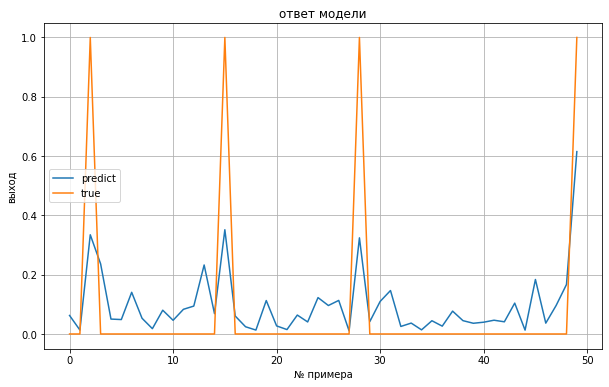

In [46]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.670, Recall=0.812
Best Threshold=0.2591879439489839, F-Score=0.734, Precision=0.670, Recall=0.812


In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1657   98]
 [  47  198]]


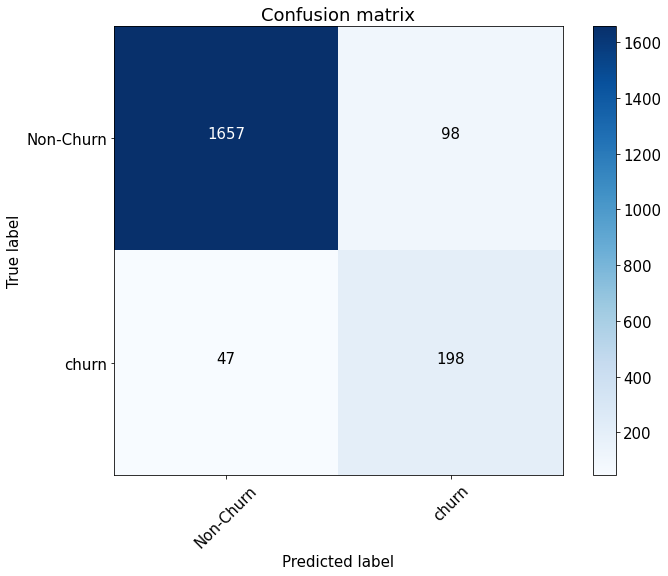

In [50]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [51]:
roc_auc_score(y_test, preds)

0.9621396592825165